#### Install

In [ ]:
%pip install captum

In [ ]:
%pip install ipywidgets

#### Import

In [1]:
import torch
from torchvision import models, transforms
from PIL import Image
from captum.attr import IntegratedGradients, NoiseTunnel
import numpy as np
import matplotlib.pyplot as plt

c:\Users\sebasn\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load model

<a href="https://deeplearning.cms.waikato.ac.nz/user-guide/class-maps/IMAGENET/">
IMAGENET class list
<a>

In [5]:
# Load a pretrained Vision Transformer model
# model = models.vit_b_16(pretrained=True)
# smaller model
model = models.vit_l_16(weights=models.ViT_L_16_Weights.IMAGENET1K_V1)
model.eval()  # Set the model to evaluation mode

VisionTransformer(
  (conv_proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=4096, out_features=1024, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
       

In [6]:
# Load an image
img_path = 'images/swan.jpg'
img = Image.open(img_path)
original_img_size = img.size

# Preprocess the image
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension


In [24]:
# Make prediction with the model
pred_label = model(input_tensor).argmax()

# Define the baseline as an all-black image
baseline = torch.zeros(input_tensor.shape) # None

# Initialize Integrated Gradients
ig = IntegratedGradients(model)

# Generate attributions for the input image
attributions, delta = ig.attribute(input_tensor, target=pred_label, baselines=baseline, return_convergence_delta=True)

#### Integrated Gradients Attribution Maps
<a href="https://matplotlib.org/stable/gallery/color/colormap_reference.html">plot colormaps</a>

In [23]:
# plotting parameters
show_plot = True
save_fig = True
apply_contrast_adjustment = True
apply_thresholding = True
tau = 5 # Keep the top tau % of intensities

overlay = False
overlay_alpha = 0.5
cmap = ['hot', 'tab20c', 'inferno', 'magma','jet','viridis'][-2]

#### Post-proccessing top accentuate features in the heatmaps

In [25]:
def threshold(heatmap, tau):
    """ keep top tau % of intensities in heatmap.
    """
    threshold = np.quantile(heatmap, (1 - tau /100))
    heatmap[heatmap < threshold] = heatmap.min()


def contrast(heatmap):
    """ applies normalization/ contrast adjustment to heatmap.
    """
    return (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())


In [13]:
# Convert attributions to a heatmap
xattributions = attributions.squeeze().cpu().detach().numpy()
heatmap = np.mean(xattributions, axis=0)

# 1. Contrast Adjustment
if apply_contrast_adjustment:
    heatmap = contrast(heatmap)

# 2. Thresholding
if apply_thresholding:
    threshold(heatmap, tau)

# 3. Normalization
if apply_normalization:
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

In [ ]:
plt.imshow(heatmap)
plt.axis('off')
plt.title('Original Image')

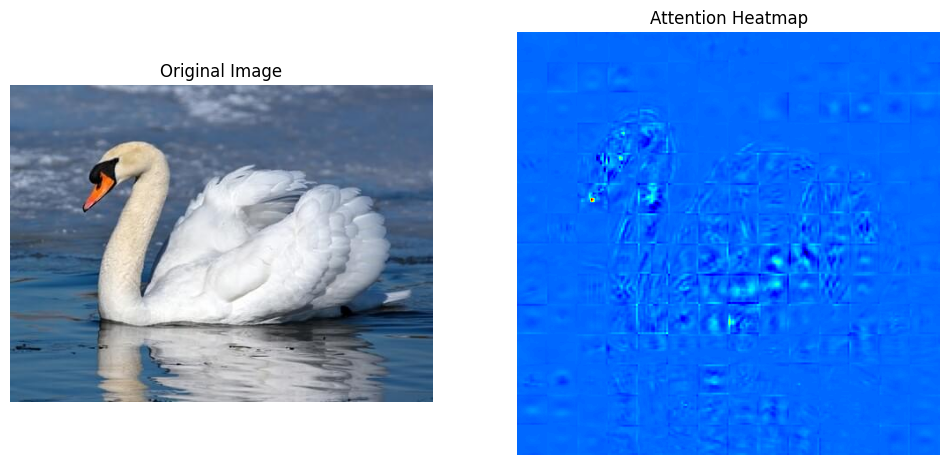

In [15]:
# Plot the original image and the heatmap
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')
plt.title('Original Image')

plt.subplot(1, 2, 2)
if overlay:
    heatmap_resized = np.array(Image.fromarray(heatmap).resize(original_img_size, Image.BILINEAR))
    plt.imshow(img, alpha=0.8)
    plt.imshow(heatmap_resized, cmap=cmap, alpha=0.6)

else:
    plt.imshow(heatmap, cmap=cmap, alpha=1)
plt.axis('off')
plt.title('Attention Heatmap')

if save_fig:
    plt.savefig('Figure_0-heatmap-comparison.png')
    
if show_plot:
    plt.show();



#### Adding Noise Tunnel to Integrated Gradients

In [22]:
# noise tunnel hyper parmaters
nt_samples = 5

# default behavior is to process all at once, by lowering this we can avoid out of mem error
nt_samples_batch_size = 1
draw_baseline_from_distrib = False
# from smoothgrad paper, noise level = 100 * sigma/ (xmax - xmin)
# optimal noise (n) in [10, 50] -> n/100 * (xmax - xmin) = sigma
n = 10
sigma = n/100 * (input_tensor.max().item() - input_tensor.min().item())
# sigma = 1.0

In [17]:
# Wrap Integrated Gradients with NoiseTunnel
noise_tunnel = NoiseTunnel(ig)

# Generate attributions using NoiseTunnel
attributions_nt = noise_tunnel.attribute(
    input_tensor, 
    nt_type='smoothgrad',
    target=pred_label,
    baselines=baseline,
    nt_samples=nt_samples,
    nt_samples_batch_size=nt_samples_batch_size,
    stdevs=sigma,
    draw_baseline_from_distrib=draw_baseline_from_distrib
)
# Convert the attributions to a numpy array for visualization
attributions_nt = attributions_nt.squeeze().cpu().detach().numpy()

In [20]:
heatmap = np.sum(attributions_nt, axis=0)

# 1. Contrast Adjustment
if apply_contrast_adjustment:
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

# 2. Thresholding
if apply_thresholding:
    threshold = np.quantile(heatmap, (1 - tau /100))
    heatmap[heatmap < threshold] = heatmap.min()

# 3. Normalization
if apply_normalization:
    heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())


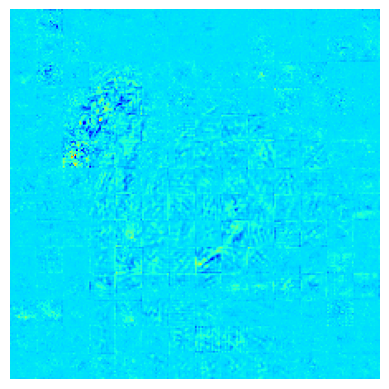

In [21]:
# Assuming 'img' is the original image that has been preprocessed
if overlay:
    plt.imshow(img)

plt.imshow(heatmap, cmap=cmap, alpha=0.5 if overlay else 1)
plt.axis('off')

if save_fig:
    plt.savefig(f'Figure_1_nt_samples-{nt_samples}_overlay-{overlay}.png'
                if sigma is not None else
                f'Figure_1_nt_samples-{nt_samples}_overlay-{overlay}_sigma-{sigma}.png'
                )

if show_plot:
    plt.show()